##Get the data ready

In [34]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
from sklearn.datasets import make_circles
#Toy dataset
n_samples = 1000
X,y = make_circles(n_samples,noise = 0.03 , random_state = 42)

In [36]:
X[:5] , y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [37]:
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[: ,1],
                        "label" : y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


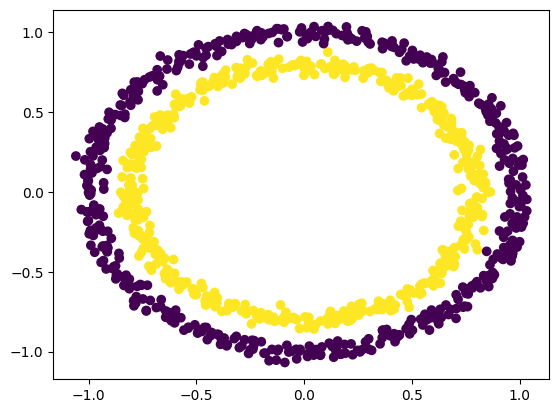

In [38]:
plt.scatter(x = X[:, 0] , y = X[:,1] , c = y )

## Turn data into tensors

In [39]:
import torch
torch.__version__

'2.0.1+cu118'

In [40]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [41]:
X[:5] , y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [42]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state=42)


## Building a model
1. Setup device agnostic code
2. construct a model by subclassing(nn.Module)
3. Define a Loss function and optimizer
4. Create a training and testing loop

In [43]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [44]:
class Classify(nn.Module):
  def __init__(self) :
    super().__init__()
    # Create nn.Linear layers
    self.layer_1 = nn.Linear(in_features = 2 , out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5 , out_features = 1) # hidden layer

    #define a forward()
    def forward(self , x):
      return self.layer2(self.layer1(x))

model_0 = Classify().to(device)
model_0


Classify(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [45]:
device

'cpu'

In [46]:
next(model_0.parameters()).device

device(type='cpu')

In [47]:
# Now lets replicate the model above using nn.Seqential

model_0 = nn.Sequential(
    nn.Linear(in_features=2 , out_features=5),
    nn.Linear(in_features=5 , out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [48]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [49]:
with torch.inference_mode():
  untrained_preds = model_0(X_test)
print(f"First 10 predictions : {untrained_preds[:10]}")
print(f"First 10 labels : {y_test[:10]}")

First 10 predictions : tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])
First 10 labels : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [50]:
## Setup loss function

#Binary Cross Entropy with logits loss
loss_fn = torch.nn.BCEWithLogitsLoss() # sigmoid acttivation function built in

optimizer = torch.optim.SGD(params = model_0.parameters() ,
                            lr = 0.01)


In [51]:
def accuracy(y_true , y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

##Train Model

1. forward pass
2. calculate the loss
3. optimizer zero grad
4. loss backward(backprop)
5. optimizer step(grad descent)

## Going from raw logits -> prediction probabilities -> prediction labels

* our model outputs are going to be raw logits
* We can convert these logits into prediction probabilities by passing them to some kind of activation function(sigmoid for binary classification and softmax for multiclass classification)
* Then we can convet our model prediction probabibilties to prediction labels by either rounding off or taking them to argmax()

In [52]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [53]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

* If y_pred_probs >= 0.5 -> class 1
*  y_pred_probs < 0.5 -> class 0

In [54]:
y_pred = torch.round(y_pred_probs)
y_pred.squeeze()

tensor([0., 0., 1., 0., 1.])

## Write a training loop and testing loop

In [55]:
torch.manual_seed(42)

epochs = 100
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  #Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss
  loss = loss_fn(y_logits , y_train) ##This bcewithlogits expects y_logits but not y_pred
  acc = accuracy(y_train , y_pred)

  #zero gradient
  optimizer.zero_grad()

  #backprop
  loss.backward()

  #graddescent
  optimizer.step()

  #Testing
  model_0.eval()
  with torch.inference_mode():
    #Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #Loss
    test_loss = loss_fn(test_logits , y_test)
    test_acc = accuracy(y_test , test_pred)
  if epoch % 10 == 0:
    print(f"Epoch : {epoch} | Loss : {loss:.3f} | acc : {acc:.3f} | Test_loss : {test_loss:.3f} | Test_acc : {test_acc:.3f}")





Epoch : 0 | Loss : 0.698 | acc : 51.875 | Test_loss : 0.695 | Test_acc : 57.500
Epoch : 10 | Loss : 0.698 | acc : 52.000 | Test_loss : 0.694 | Test_acc : 58.000
Epoch : 20 | Loss : 0.697 | acc : 52.000 | Test_loss : 0.694 | Test_acc : 57.500
Epoch : 30 | Loss : 0.697 | acc : 52.000 | Test_loss : 0.694 | Test_acc : 56.500
Epoch : 40 | Loss : 0.697 | acc : 51.625 | Test_loss : 0.694 | Test_acc : 56.500
Epoch : 50 | Loss : 0.697 | acc : 51.375 | Test_loss : 0.694 | Test_acc : 56.000
Epoch : 60 | Loss : 0.697 | acc : 51.375 | Test_loss : 0.694 | Test_acc : 56.000
Epoch : 70 | Loss : 0.696 | acc : 51.375 | Test_loss : 0.693 | Test_acc : 56.500
Epoch : 80 | Loss : 0.696 | acc : 51.250 | Test_loss : 0.693 | Test_acc : 56.500
Epoch : 90 | Loss : 0.696 | acc : 51.375 | Test_loss : 0.693 | Test_acc : 55.000


## Visualize
From the metrics it looks like our model isn't learning anything ...

We're going to visualise what went wrong

In [56]:
import requests
from pathlib import Path

# Download helper fns from Learn Pytorch repo
if Path("helper_functions.py").is_file() :
  print("helper_functions.py already exists , skipping download")
else :
  print("Downloading...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py" , "wb") as f :
    f.write(request.content)

helper_functions.py already exists , skipping download


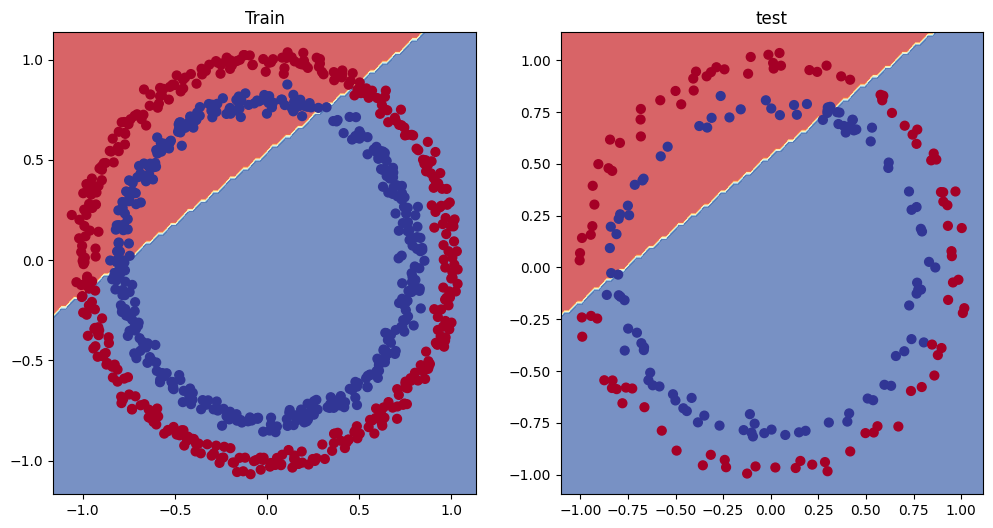

In [57]:
from helper_functions import plot_predictions , plot_decision_boundary

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0 , X_test , y_test)

## Improve the model

* Add more no of layers
* Add more no of hidden units
* Fit for longer
* Changing the activation fn
* Changing the learning rate

In [58]:
class Classify_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2 , out_features=10)
    self.layer_2 = nn.Linear(in_features=10 , out_features=10)
    self.layer_3 = nn.Linear(in_features= 10 , out_features=1)

  def forward(self , x):
    z_1 = self.layer_1(x)
    z_2 = self.layer_2(z_1)
    z_3 = self.layer_3(z_2)
    return z_3

model_1 = Classify_1()
model_1

Classify_1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [59]:
#Create a loss fn
loss_fn = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.SGD(params = model_1.parameters() , lr = 0.01)

In [60]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs) :
  model_1.train()

  #Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  #Calculate loss
  loss = loss_fn(y_logits , y_train)
  acc = accuracy(y_train , y_pred)
  #Zero grad
  optimizer.zero_grad()
  #Backward
  loss.backward()
  #Grad descent
  optimizer.step()

  #Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits , y_test)
    test_acc = accuracy(y_test, test_pred)
  if epoch % 100 == 0 :
    print(f"Epoch : {epoch} | Loss : {loss:.3f} | acc : {acc:.3f} | Test_loss : {test_loss:.3f} | Test_acc : {test_acc:.3f}")



Epoch : 0 | Loss : 0.694 | acc : 50.875 | Test_loss : 0.693 | Test_acc : 51.000
Epoch : 100 | Loss : 0.694 | acc : 50.250 | Test_loss : 0.693 | Test_acc : 50.000
Epoch : 200 | Loss : 0.694 | acc : 50.125 | Test_loss : 0.693 | Test_acc : 49.500
Epoch : 300 | Loss : 0.693 | acc : 50.500 | Test_loss : 0.693 | Test_acc : 49.000
Epoch : 400 | Loss : 0.693 | acc : 50.375 | Test_loss : 0.693 | Test_acc : 48.500
Epoch : 500 | Loss : 0.693 | acc : 49.875 | Test_loss : 0.693 | Test_acc : 49.500
Epoch : 600 | Loss : 0.693 | acc : 49.500 | Test_loss : 0.693 | Test_acc : 53.000
Epoch : 700 | Loss : 0.693 | acc : 49.375 | Test_loss : 0.693 | Test_acc : 50.500
Epoch : 800 | Loss : 0.693 | acc : 50.000 | Test_loss : 0.694 | Test_acc : 51.000
Epoch : 900 | Loss : 0.693 | acc : 50.625 | Test_loss : 0.694 | Test_acc : 47.500


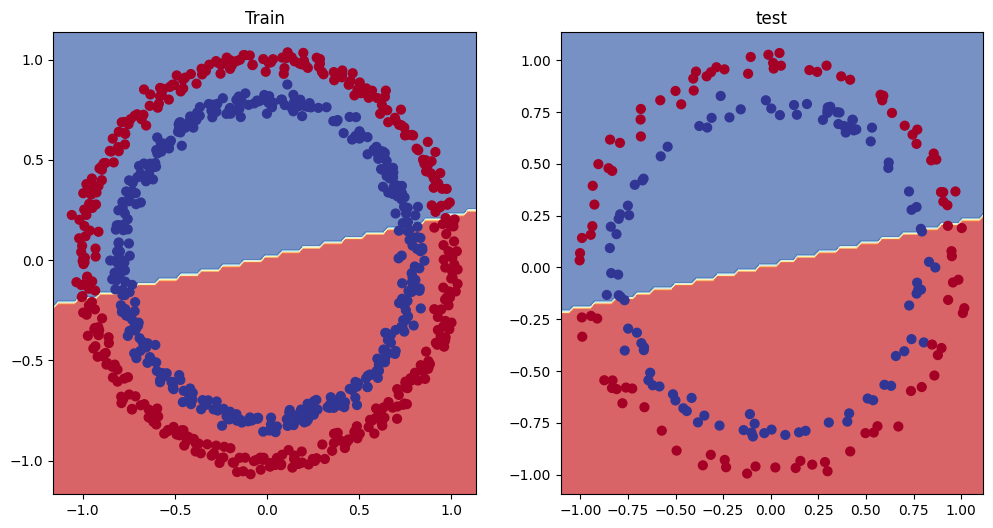

In [61]:
# Plot the decision boundary

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_1 , X_test , y_test)

## Build non linear activation functions

In [76]:
class Classify_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2 , out_features=10)
    self.layer_2 = nn.Linear(in_features=10 , out_features=10)
    self.layer_3 = nn.Linear(in_features= 10 , out_features=1)
    self.relu = nn.ReLU() # non linear activation function


  def forward(self , x):
    z_1 = self.layer_1(x)
    z_2 = self.layer_2(self.relu(z_1))
    z_3 = self.layer_3(self.relu(z_2))
    return z_3

model_2 = Classify_2()
model_2

Classify_2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [77]:
#Create a loss fn
loss_fn = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(params = model_2.parameters() , lr = 0.1)

In [78]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs) :
  model_2.train()

  #Forward pass
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  #Calculate loss
  loss = loss_fn(y_logits , y_train)
  acc = accuracy(y_train , y_pred)
  #Zero grad
  optimizer.zero_grad()
  #Backward
  loss.backward()
  #Grad descent
  optimizer.step()

  #Testing
  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits , y_test)
    test_acc = accuracy(y_test, test_pred)
  if epoch % 100 == 0 :
    print(f"Epoch : {epoch} | Loss : {loss:.3f} | acc : {acc:.3f} | Test_loss : {test_loss:.3f} | Test_acc : {test_acc:.3f}")


Epoch : 0 | Loss : 0.693 | acc : 50.000 | Test_loss : 0.694 | Test_acc : 50.000
Epoch : 100 | Loss : 0.002 | acc : 100.000 | Test_loss : 0.007 | Test_acc : 100.000
Epoch : 200 | Loss : 0.001 | acc : 100.000 | Test_loss : 0.005 | Test_acc : 100.000
Epoch : 300 | Loss : 0.000 | acc : 100.000 | Test_loss : 0.005 | Test_acc : 100.000
Epoch : 400 | Loss : 0.000 | acc : 100.000 | Test_loss : 0.006 | Test_acc : 100.000
Epoch : 500 | Loss : 0.000 | acc : 100.000 | Test_loss : 0.005 | Test_acc : 100.000
Epoch : 600 | Loss : 0.000 | acc : 100.000 | Test_loss : 0.005 | Test_acc : 100.000
Epoch : 700 | Loss : 0.000 | acc : 100.000 | Test_loss : 0.005 | Test_acc : 100.000
Epoch : 800 | Loss : 0.000 | acc : 100.000 | Test_loss : 0.006 | Test_acc : 100.000
Epoch : 900 | Loss : 0.000 | acc : 100.000 | Test_loss : 0.006 | Test_acc : 100.000


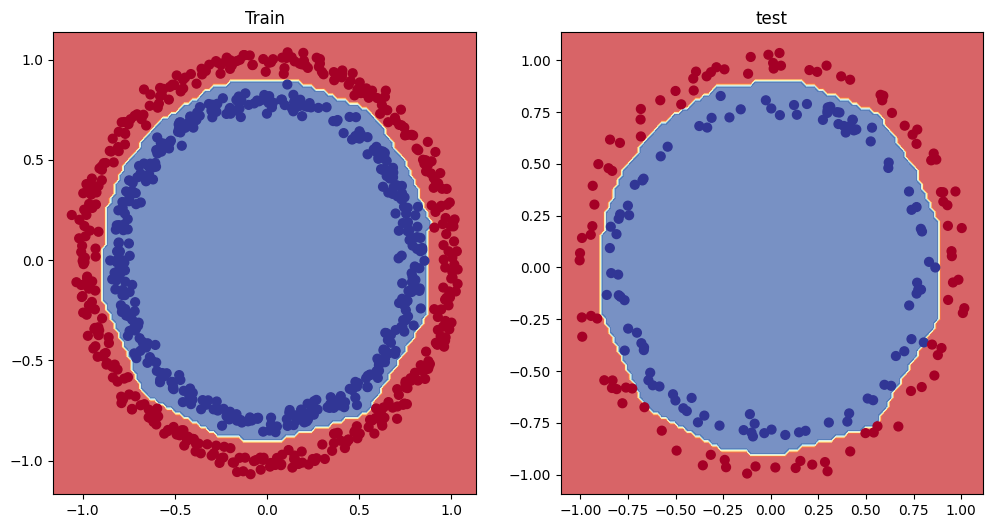

In [79]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_2 , X_test , y_test)

In [80]:
# Refer the trouble shooting part in the video